![](https://raw.githubusercontent.com/UGS-CS/CSC3009/master/mashead.svg)

# <center>**Team 16**</center>

In [2]:
# import libaries
from google.colab import drive
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

In [3]:
try:
  drive.mount('/content/drive/')
except Exception as e:
    print(f"Error mounting Google Drive: {e}. Please ensure you are running in Google Colab.")

Mounted at /content/drive/


## **1. Exploratory data analysis**

In [4]:
# Define paths
DATASET_PATH = "drive/MyDrive/dataset"

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

Starting EDA on dataset at: drive/MyDrive/dataset

## 1. Class Distribution
---
Training Set Counts: {'glioma': 120, 'meningioma': 120, 'notumor': 120, 'pituitary': 120}
Test Set Counts: {'glioma': 120, 'meningioma': 120, 'notumor': 120, 'pituitary': 120}


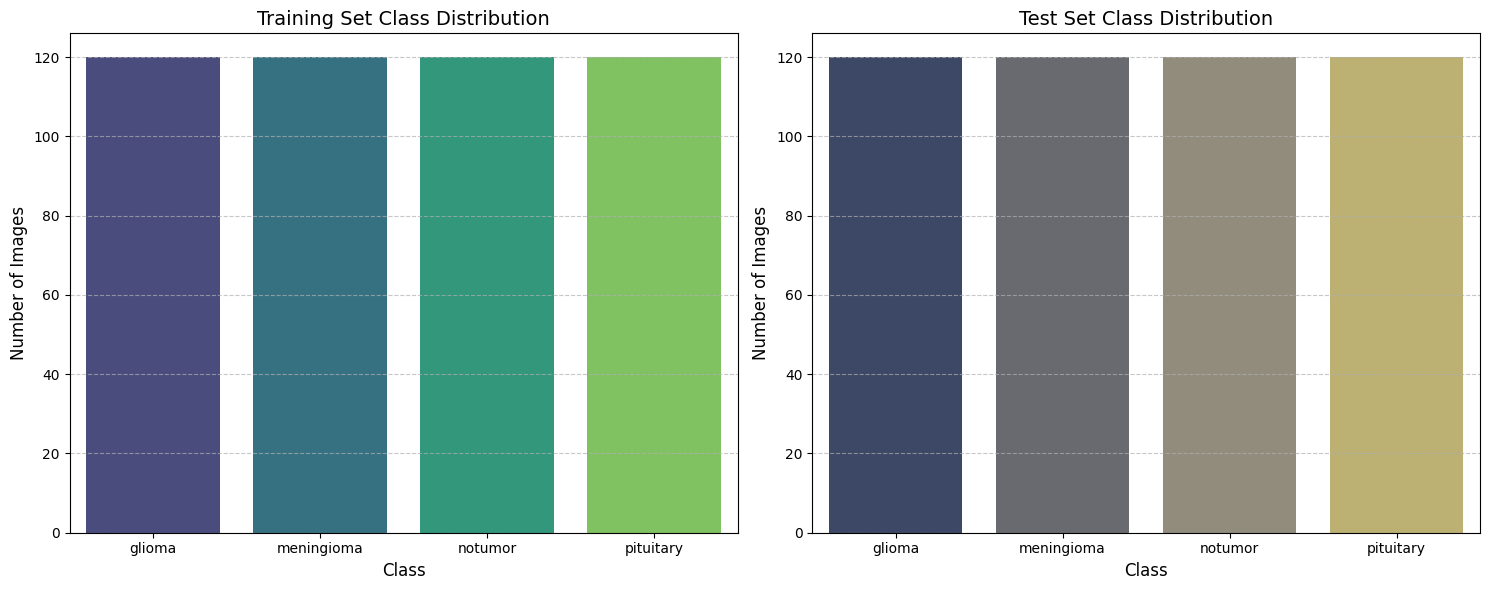


## 2. Image Size Analysis
---
  Processing image sizes for: training/glioma
  Processing image sizes for: training/meningioma
  Processing image sizes for: training/notumor
  Processing image sizes for: training/pituitary
  Processing image sizes for: test/glioma
  Processing image sizes for: test/meningioma
  Processing image sizes for: test/notumor
  Processing image sizes for: test/pituitary

Processed sizes for 960 images.

Image Size Summary (Height x Width):
            Height        Width
count   960.000000   960.000000
mean    452.014583   448.407292
std     124.663835   129.302499
min     168.000000   150.000000
25%     435.250000   414.500000
50%     512.000000   512.000000
75%     512.000000   512.000000
max    1019.000000  1149.000000


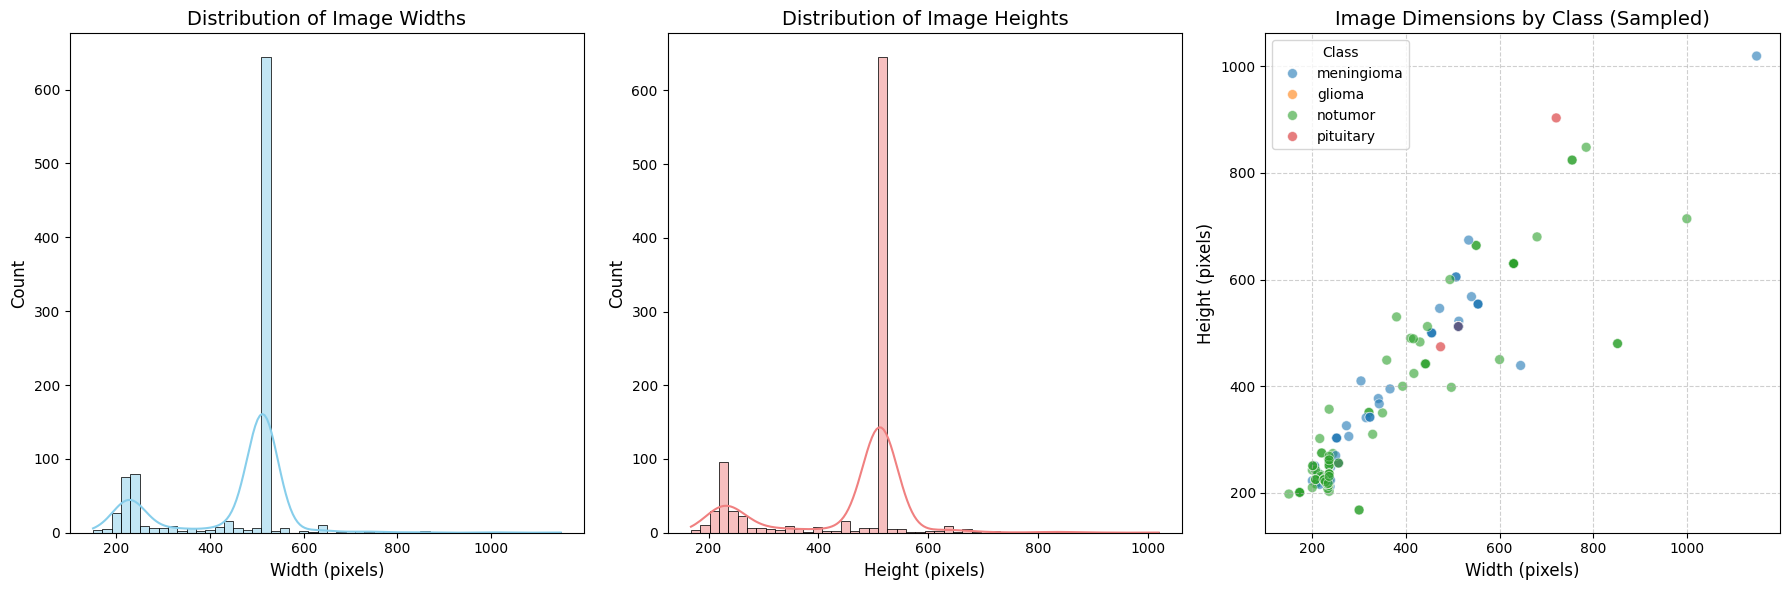

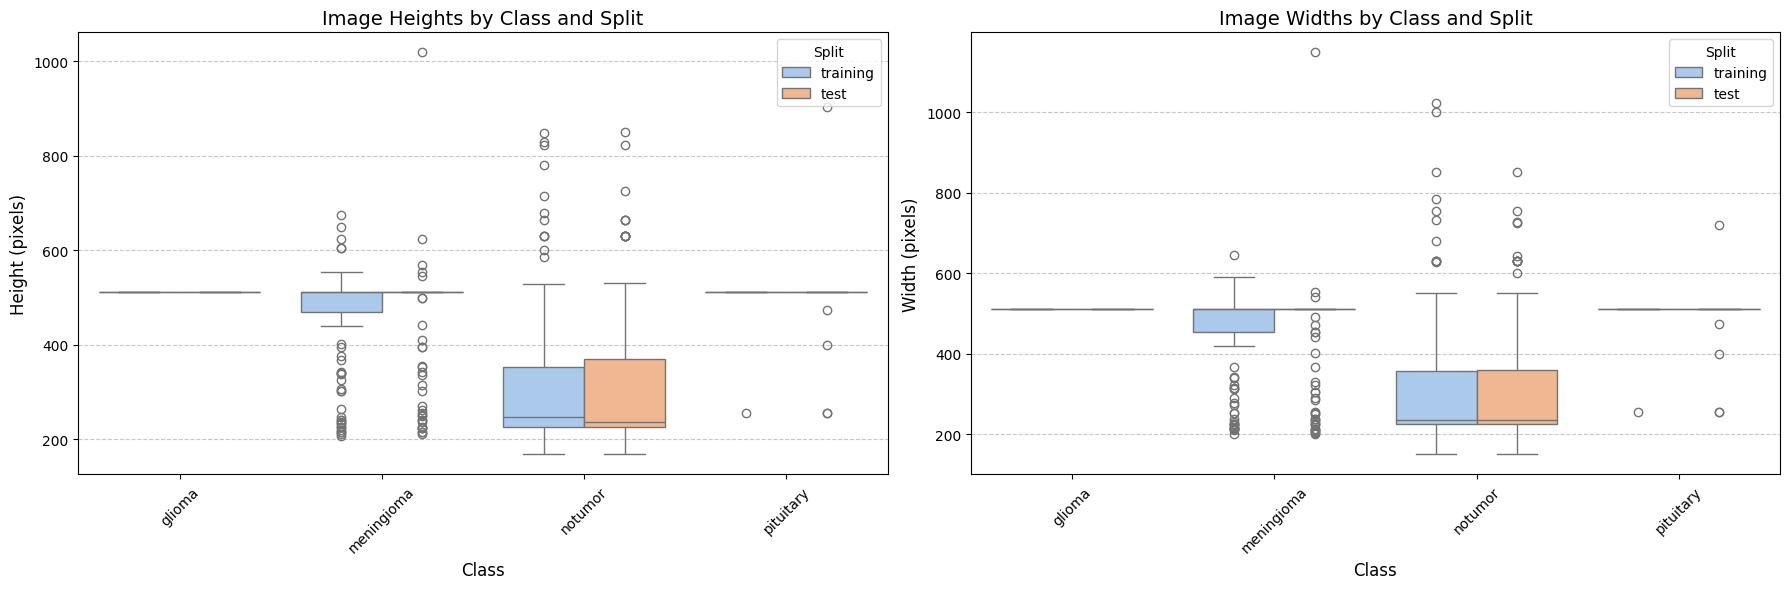


## 3. Image Overlap Check
---
  Attempting to list image IDs from: drive/MyDrive/dataset/training/dataset_16/glioma
    Found 120 unique IDs for training_glioma
  Attempting to list image IDs from: drive/MyDrive/dataset/training/dataset_16/meningioma
    Found 120 unique IDs for training_meningioma
  Attempting to list image IDs from: drive/MyDrive/dataset/training/dataset_16/notumor
    Found 120 unique IDs for training_notumor
  Attempting to list image IDs from: drive/MyDrive/dataset/training/dataset_16/pituitary
    Found 120 unique IDs for training_pituitary
  Attempting to list image IDs from: drive/MyDrive/dataset/test/glioma
    Found 120 unique IDs for test_glioma
  Attempting to list image IDs from: drive/MyDrive/dataset/test/meningioma
    Found 120 unique IDs for test_meningioma
  Attempting to list image IDs from: drive/MyDrive/dataset/test/notumor
    Found 120 unique IDs for test_notumor
  Attempting to list image IDs from: drive/MyDrive/dataset/test/pituitary
    Found

In [5]:
def eda_analysis():
    print(f"Starting EDA on dataset at: {DATASET_PATH}\n")

    # --- 1. Class Distribution ---
    print("## 1. Class Distribution")
    print("---")
    train_counts = {}
    test_counts = {}

    for cls in CLASSES:
        train_path = os.path.join(DATASET_PATH, 'training', 'dataset_16', cls)
        test_path = os.path.join(DATASET_PATH, 'test', cls) # Assuming no 'dataset_16' for test

        if os.path.exists(train_path):
            train_counts[cls] = len(os.listdir(train_path))
        else:
            print(f"Warning: Training directory not found for {cls}: {train_path}")
            train_counts[cls] = 0

        if os.path.exists(test_path):
            test_counts[cls] = len(os.listdir(test_path))
        else:
            print(f"Warning: Test directory not found for {cls}: {test_path}")
            test_counts[cls] = 0

    print("Training Set Counts:", train_counts)
    print("Test Set Counts:", test_counts)

    # Visualization for Class Distribution
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette='viridis', hue=list(train_counts.keys()), legend=False)
    plt.title("Training Set Class Distribution", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), palette='cividis', hue=list(test_counts.keys()), legend=False)
    plt.title("Test Set Class Distribution", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- 2. Image Size Analysis ---
    print("\n## 2. Image Size Analysis")
    print("---")
    size_stats = defaultdict(list) # Stores (height, width) tuples
    total_images_processed = 0

    for split in ['training', 'test']:
        for cls in CLASSES:
            current_image_dir = ""
            if split == 'training':
                current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)
            elif split == 'test':
                # CONFIRM THIS PATH FOR TEST SET:
                current_image_dir = os.path.join(DATASET_PATH, split, cls)
                # If test also has 'dataset_16':
                # current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)

            print(f"  Processing image sizes for: {split}/{cls}")
            if not os.path.exists(current_image_dir):
                print(f"    Warning: Directory not found: {current_image_dir}. Skipping.")
                continue

            for img_name in os.listdir(current_image_dir):
                img_path = os.path.join(current_image_dir, img_name)
                if os.path.isfile(img_path): # Ensure it's a file
                    try:
                        img_raw = tf.io.read_file(img_path)
                        img_tensor = tf.image.decode_image(img_raw, channels=3)

                        if len(img_tensor.shape) >= 2: # Ensure it has at least height and width
                             size_stats[f"{split}_{cls}"].append((img_tensor.shape[0], img_tensor.shape[1]))
                        else:
                            print(f"    Warning: Unexpected shape for image {img_name}: {img_tensor.shape}. Skipping.")

                        total_images_processed += 1
                    except tf.errors.InvalidArgumentError as e:
                        print(f"    Warning: Could not decode image {img_name} in {split}/{cls}. Error: {e}")
                    except Exception as e:
                        print(f"    Warning: Error processing {img_name} in {split}/{cls}. Error: {e}")

    print(f"\nProcessed sizes for {total_images_processed} images.")

    # Analyze and visualize sizes
    all_widths = []
    all_heights = []

    # Convert size stats to a DataFrame for easier plotting
    size_df_data = []
    for key, sizes_list in size_stats.items():
        split_name, class_name = key.split('_')
        for h, w in sizes_list:
            size_df_data.append({'Split': split_name, 'Class': class_name, 'Height': h, 'Width': w})
            all_widths.append(w)
            all_heights.append(h)

    if size_df_data:
        size_df = pd.DataFrame(size_df_data)

        print("\nImage Size Summary (Height x Width):")
        print(size_df[['Height', 'Width']].describe())

        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        sns.histplot(all_widths, bins=50, kde=True, color='skyblue')
        plt.title("Distribution of Image Widths", fontsize=14)
        plt.xlabel("Width (pixels)", fontsize=12)
        plt.ylabel("Count", fontsize=12)

        plt.subplot(1, 3, 2)
        sns.histplot(all_heights, bins=50, kde=True, color='lightcoral')
        plt.title("Distribution of Image Heights", fontsize=14)
        plt.xlabel("Height (pixels)", fontsize=12)
        plt.ylabel("Count", fontsize=12)

        plt.subplot(1, 3, 3)
        # Sample for scatter plot if too many points
        sample_df = size_df.sample(min(500, len(size_df))) if len(size_df) > 500 else size_df
        sns.scatterplot(data=sample_df, x='Width', y='Height', hue='Class', alpha=0.6, s=50, palette='tab10')
        plt.title("Image Dimensions by Class (Sampled)", fontsize=14)
        plt.xlabel("Width (pixels)", fontsize=12)
        plt.ylabel("Height (pixels)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Box plot for sizes by class
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(data=size_df, x='Class', y='Height', hue='Split', palette='pastel')
        plt.title("Image Heights by Class and Split", fontsize=14)
        plt.xlabel("Class", fontsize=12)
        plt.ylabel("Height (pixels)", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.subplot(1, 2, 2)
        sns.boxplot(data=size_df, x='Class', y='Width', hue='Split', palette='pastel')
        plt.title("Image Widths by Class and Split", fontsize=14)
        plt.xlabel("Class", fontsize=12)
        plt.ylabel("Width (pixels)", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    else:
        print("No image size data collected. Ensure paths are correct and images are present.")


    # --- 3. Image Overlap Check ---
    print("\n## 3. Image Overlap Check")
    print("---")
    image_ids = {} # Stores sets of IDs for each split_class combination

    for split in ['training', 'test']:
        for cls in CLASSES:
            current_image_dir = ""
            if split == 'training':
                current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)
            elif split == 'test':
                # CONFIRM THIS PATH FOR TEST SET:
                current_image_dir = os.path.join(DATASET_PATH, split, cls)
                # If test also has 'dataset_16':
                # current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)

            print(f"  Attempting to list image IDs from: {current_image_dir}")

            if os.path.exists(current_image_dir):
                ids = set()
                try:
                    for f in os.listdir(current_image_dir):
                        file_path = os.path.join(current_image_dir, f)
                        if os.path.isfile(file_path):
                            # CORRECTED LINE: Use the full filename without extension as the ID
                            ids.add(os.path.splitext(f)[0])
                except Exception as e:
                    print(f"    Error listing files in {current_image_dir}: {e}")
                    ids = set()

                image_ids[f"{split}_{cls}"] = ids
                print(f"    Found {len(ids)} unique IDs for {split}_{cls}")
            else:
                print(f"    Warning: Directory not found for image ID check: {current_image_dir}. Skipping {split}/{cls}.")
                image_ids[f"{split}_{cls}"] = set()


    # --- 4. Missing or Corrupted Image Check ---
    print("\n## 4. Missing or Corrupted Image Check")
    print("---")
    missing_or_corrupted = defaultdict(list)

    for split in ['training', 'test']:
        for cls in CLASSES:
            current_image_dir = ""
            if split == 'training':
                current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)
            elif split == 'test':
                current_image_dir = os.path.join(DATASET_PATH, split, cls)

            if not os.path.exists(current_image_dir):
                print(f"  Skipping {split}/{cls} - directory does not exist.")
                continue

            print(f"  Checking images in: {split}/{cls}")
            for img_name in os.listdir(current_image_dir):
                img_path = os.path.join(current_image_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        img_raw = tf.io.read_file(img_path)
                        _ = tf.image.decode_image(img_raw, channels=3)
                    except Exception as e:
                        missing_or_corrupted[f"{split}_{cls}"].append((img_name, str(e)))

    # Report corrupted images
    total_missing = sum(len(v) for v in missing_or_corrupted.values())
    print(f"\nTotal missing or corrupted images: {total_missing}")

    if total_missing > 0:
        for key, problems in missing_or_corrupted.items():
            print(f"\n  {key} - {len(problems)} issues")
            for filename, error in problems[:5]:  # Show up to 5 per class
                print(f"    {filename}: {error}")
        print("\n  **WARNING: Some images are unreadable or corrupted. Consider removing or replacing them.**")
    else:
        print("  ✅ All images are readable. No missing or corrupted files detected.")


    # --- Compare Training and Test Sets for Overall Overlap ---
    print("\n--- Comparing Training and Test Sets for Overall Overlap ---")

    all_train_ids = set()
    for cls in CLASSES:
        all_train_ids.update(image_ids.get(f"training_{cls}", set()))

    all_test_ids = set()
    for cls in CLASSES:
        all_test_ids.update(image_ids.get(f"test_{cls}", set()))

    overall_overlap = all_train_ids.intersection(all_test_ids)

    print(f"Total unique IDs in Training Set: {len(all_train_ids)}")
    print(f"Total unique IDs in Test Set:     {len(all_test_ids)}")
    print(f"Total unique IDs overlapping between Training and Test Sets: {len(overall_overlap)}")

    if len(overall_overlap) > 0:
        print(f"  Example overlapping IDs: {list(overall_overlap)[:5]} (showing up to 5 examples)")
        print("\n  **WARNING: OVERLAP DETECTED!** This means some images (or their direct variations) are present in both training and test sets.")
        print("  This can lead to **overly optimistic model performance metrics** during evaluation.")
        print("  Consider re-splitting your dataset to ensure strict separation between training and test data if this is unintentional.")
    else:
        print("  No overlap detected between training and test sets. This is ideal for robust model evaluation.")

    print("\nEDA Complete!")

# Execute the analysis
eda_analysis()

Found 480 files belonging to 4 classes.
Found 480 files belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']

🔍 Training Batch Shape:
Images shape: (32, 224, 224, 3)
Labels shape: (32,)

First Image Shape: (224, 224, 3)
First Image Pixel Values (as uint8):
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Class index of first image: 0


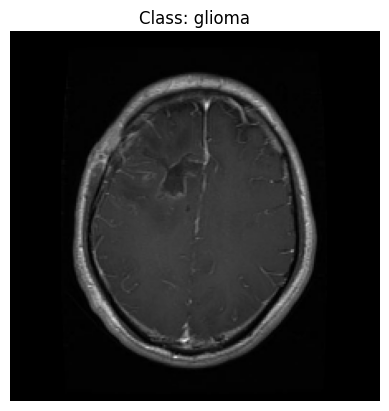

In [6]:
# Load datasets
# Define paths
# Correct the DATASET_PATH to point to the root of your dataset on Google Drive
DATASET_PATH = "drive/MyDrive/dataset"

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Use os.path.join with the DATASET_PATH variable
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "training", "dataset_16"),
    image_size=(224, 224),   # You can change this size
    batch_size=32,
    shuffle=False
)

# Update the test path as well to use DATASET_PATH
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "test"), # Assuming the test data is directly under 'test'
    image_size=(224, 224),
    batch_size=32
)

# View class names
print("Class names:", train_ds.class_names)

# Inspect one batch from training dataset
for images, labels in train_ds.take(1):
    print("\n🔍 Training Batch Shape:")
    print("Images shape:", images.shape)  # (batch_size, height, width, channels)
    print("Labels shape:", labels.shape)

    # Get first image
    image = images[0].numpy()
    label = labels[0].numpy()

    print("\nFirst Image Shape:", image.shape)
    print("First Image Pixel Values (as uint8):")
    print(image.astype(np.uint8))  # You can also use np.round(image) for cleaner output
    print("Class index of first image:", label)
    break


# Display the first image
plt.imshow(image.astype("uint8"))  # Convert to uint8 for proper color rendering
plt.title(f"Class: {train_ds.class_names[label]}")
plt.axis("off")
plt.show()



Check images with no pixel variation (potentially blank)

In [7]:
def check_blank_images(dataset):
    blank_count = 0
    total = 0
    for image_batch, label_batch in dataset:
        for img in image_batch:
            total += 1
            if np.std(img.numpy()) == 0:  # All pixels same
                blank_count += 1
    print(f"Blank images: {blank_count}/{total}")
check_blank_images(train_ds)

Blank images: 0/480


## **2. Data preparation and pre-processing**

### Create Metadata File

In [8]:
def prepare_metadata_table(dataset_dir, class_names, id_delimiter='_', id_parts=2, image_extensions={'.jpg', '.jpeg', '.png'}):
    """
    Prepares metadata table with renamed class labels.

    Args:
        dataset_dir (str): Path to dataset folder
        class_names (list): Target class names, used in order
        id_delimiter (str): Delimiter for parsing ID from filename
        id_parts (int): Number of parts to keep from split filename
        image_extensions (set): Acceptable image file extensions

    Returns:
        pd.DataFrame: Metadata table with columns: path, label, id
    """
    data = []
    subfolders = sorted(os.listdir(dataset_dir))  # Assumes order matches class_names
    class_map = {orig: new for orig, new in zip(subfolders, class_names)}

    for folder in subfolders:
        folder_path = os.path.join(dataset_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        label = class_map.get(folder)
        if label is None:
            continue

        for filename in os.listdir(folder_path):
            ext = os.path.splitext(filename)[1].lower()
            if ext not in image_extensions:
                continue

            full_path = os.path.join(folder_path, filename)

            name_wo_ext = os.path.splitext(filename)[0]
            id_parts_split = name_wo_ext.split(id_delimiter)[:id_parts]
            unique_id = id_delimiter.join(id_parts_split)

            data.append({
                'path': full_path,
                'label': label,
                'id': unique_id
            })

    df = pd.DataFrame(data)
    print(f"✅ Metadata table created with {len(df)} entries.")
    print(df.head())
    return df


In [9]:
DATASET_PATH_TRAIN = "drive/MyDrive/dataset/training/dataset_16"
DATASET_PATH_TEST = "drive/MyDrive/dataset/test"  # Corrected the directory name from 'testing' to 'test'
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Assuming folder names are already correct (e.g., "glioma", "pituitary"), no mapping is needed
train_df = prepare_metadata_table(DATASET_PATH_TRAIN, CLASSES)
test_df = prepare_metadata_table(DATASET_PATH_TEST, CLASSES)

✅ Metadata table created with 480 entries.
                                                path   label          id
0  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Tr-gl_0109
1  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Te-gl_0129
2  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Tr-gl_0120
3  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Te-gl_0079
4  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Te-gl_0178
✅ Metadata table created with 480 entries.
                                               path   label          id
0  drive/MyDrive/dataset/test/glioma/Te-gl_0170.jpg  glioma  Te-gl_0170
1  drive/MyDrive/dataset/test/glioma/Te-gl_0167.jpg  glioma  Te-gl_0167
2  drive/MyDrive/dataset/test/glioma/Tr-gl_0107.jpg  glioma  Tr-gl_0107
3  drive/MyDrive/dataset/test/glioma/Tr-gl_0277.jpg  glioma  Tr-gl_0277
4  drive/MyDrive/dataset/test/glioma/Tr-gl_0061.jpg  glioma  Tr-gl_0061


### Data Augmentation
Apply data augmentation to the training set to increase dataset diversity and prevent overfitting. This is especially important for medical imaging tasks like brain tumor classification, where data may be limited.

In [9]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import shutil
import random

DATASET_PATH = "drive/MyDrive/dataset"
TRAIN_DIR = os.path.join(DATASET_PATH, "training/dataset_16")
TEST_DIR = os.path.join(DATASET_PATH, "test")
AUGMENTED_TRAIN_DIR = os.path.join(DATASET_PATH, "augmented_train")
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Create output folders
def create_augmented_folders(base_dir, class_names):
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
    os.makedirs(base_dir)
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name))

create_augmented_folders(AUGMENTED_TRAIN_DIR, CLASSES)

# Data augmentation config
datagen = ImageDataGenerator(
    rotation_range=20,                # Slightly more rotation
    width_shift_range=0.1,           # Up to 10% shift
    height_shift_range=0.1,
    shear_range=0.1,                 # Slightly more distortion
    zoom_range=0.15,                 # Slightly stronger zoom
    brightness_range=(0.8, 1.2),     # Simulate lighting variation
    horizontal_flip=True,
    fill_mode='reflect'              # More natural padding than 'nearest'
)


# Augment each image to make 4 versions (480 original → 1920 total)
def augment_training_set(train_dir, augmented_dir, class_names, copies_per_image=4):
    for class_name in class_names:
        input_class_dir = os.path.join(train_dir, class_name)
        output_class_dir = os.path.join(augmented_dir, class_name)

        for fname in os.listdir(input_class_dir):
            if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(input_class_dir, fname)
            img = load_img(img_path)  # PIL image
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            # Save augmented images
            prefix = os.path.splitext(fname)[0]
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                                      save_to_dir=output_class_dir,
                                      save_prefix=prefix,
                                      save_format='jpg'):
                i += 1
                if i >= copies_per_image:
                    break

augment_training_set(TRAIN_DIR, AUGMENTED_TRAIN_DIR, CLASSES)


In [10]:
print(f"Number of augmented training images: {sum(len(os.listdir(os.path.join(AUGMENTED_TRAIN_DIR, cls))) for cls in CLASSES)}")
print(f"Number of test images: {sum(len(os.listdir(os.path.join(TEST_DIR, cls))) for cls in CLASSES)}")


Number of augmented training images: 1920
Number of test images: 480


###Standardize & Normalize Image Sizes
To have all images same size and pixels to ensure consistency in the data.

In [11]:
import tensorflow as tf
import os

# Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Paths
AUGMENTED_TRAIN_DIR = "drive/MyDrive/dataset/augmented_train"
TEST_DIR = "drive/MyDrive/dataset/test"

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    AUGMENTED_TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for one-hot labels
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True
)

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',  # Must match train_ds
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False
)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Optional normalization (rescale 0–255 to 0–1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)


Found 1920 files belonging to 4 classes.
Found 480 files belonging to 4 classes.


In [12]:
print("\n--- Checking dataset sizes after augmentation ---")

# Function to count files in each class subfolder
def count_images_in_directory(directory, class_names):
    counts = {}
    total = 0
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return counts, 0

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.exists(class_path):
            # Count only image files (ignoring hidden files etc.)
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            counts[class_name] = len(files)
            total += len(files)
        else:
            print(f"Class directory not found: {class_path}")
            counts[class_name] = 0
    return counts, total

# Count augmented training images
augmented_train_counts, total_augmented_train = count_images_in_directory(AUGMENTED_TRAIN_DIR, CLASSES)
print(f"Augmented Training Dataset Counts: {augmented_train_counts}")
print(f"Total Augmented Training Images: {total_augmented_train}")

# Count test images (should be the same as before augmentation)
test_counts, total_test = count_images_in_directory(TEST_DIR, CLASSES)
print(f"Test Dataset Counts: {test_counts}")
print(f"Total Test Images: {total_test}")

# Optional: Verify counts from tf.keras.utils.image_dataset_from_directory batches
# This is less direct but can confirm what the dataset object sees
print("\nVerifying counts using tf.data dataset objects:")

# Function to get the number of elements in a tf.data dataset
def count_dataset_elements(dataset):
    # Warning: Iterating through the dataset like this can be slow for very large datasets
    return sum(1 for _ in dataset.unbatch())

try:
    # Get the total number of elements (images) by unbatching
    total_train_ds_images = count_dataset_elements(train_ds)
    print(f"Total images loaded into train_ds object: {total_train_ds_images}")
except Exception as e:
    print(f"Could not count elements in train_ds (might be prefetched/cached): {e}")
    print("Relying on file counts for augmented training set size.")

try:
    total_test_ds_images = count_dataset_elements(test_ds)
    print(f"Total images loaded into test_ds object: {total_test_ds_images}")
except Exception as e:
     print(f"Could not count elements in test_ds (might be prefetched/cached): {e}")
     print("Relying on file counts for test set size.")




--- Checking dataset sizes after augmentation ---
Augmented Training Dataset Counts: {'glioma': 480, 'meningioma': 480, 'notumor': 480, 'pituitary': 480}
Total Augmented Training Images: 1920
Test Dataset Counts: {'glioma': 120, 'meningioma': 120, 'notumor': 120, 'pituitary': 120}
Total Test Images: 480

Verifying counts using tf.data dataset objects:
Total images loaded into train_ds object: 1920
Total images loaded into test_ds object: 480


### Verify Preprocessed Data


--- ✅ Verifying Dataset Shapes and Visualizing Augmentations ---

🔍 Preprocessed Training Batch Info:
✅ Images shape: (32, 224, 224, 3)
✅ Labels shape: (32, 4)
✅ Pixel range: 0.0 to 1.0


/tmp/ipython-input-13-543698671.py:27: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


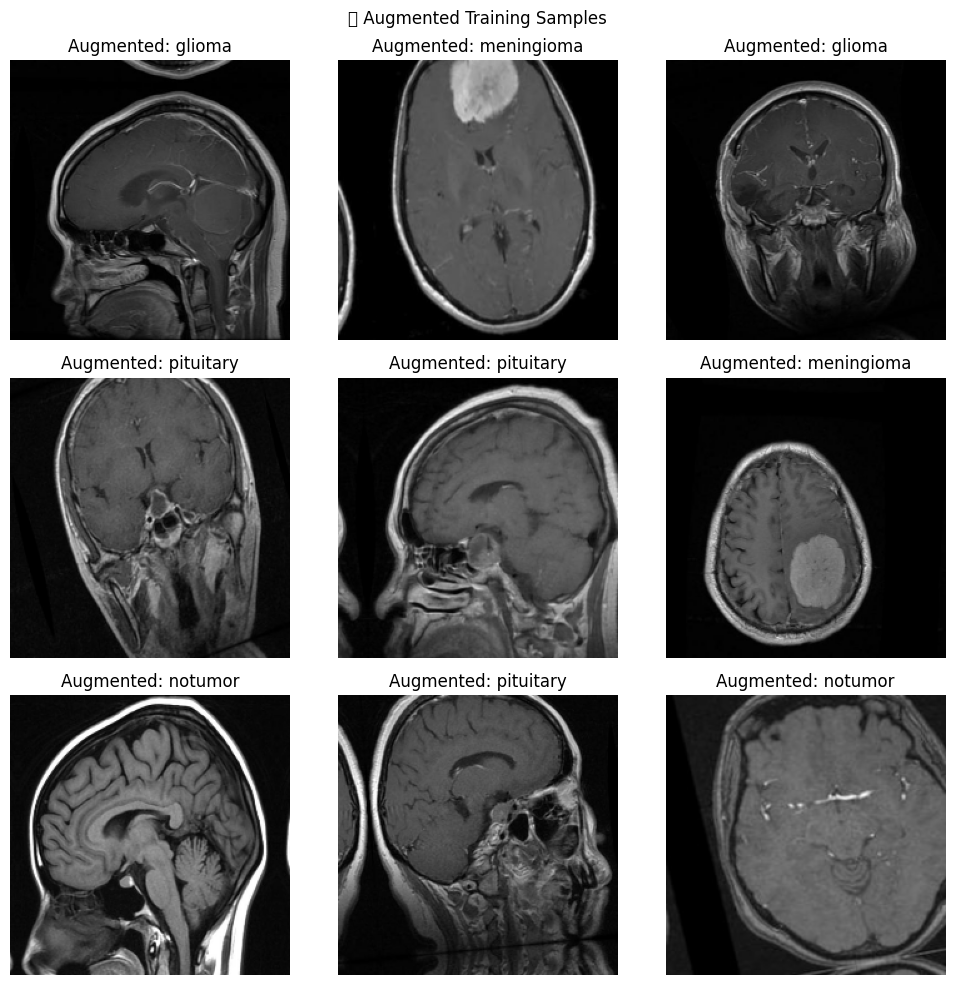


🔍 Preprocessed Test Batch Info:
✅ Images shape: (32, 224, 224, 3)
✅ Labels shape: (32, 4)
✅ Pixel range: 0.0 to 0.9888555


/tmp/ipython-input-13-543698671.py:47: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


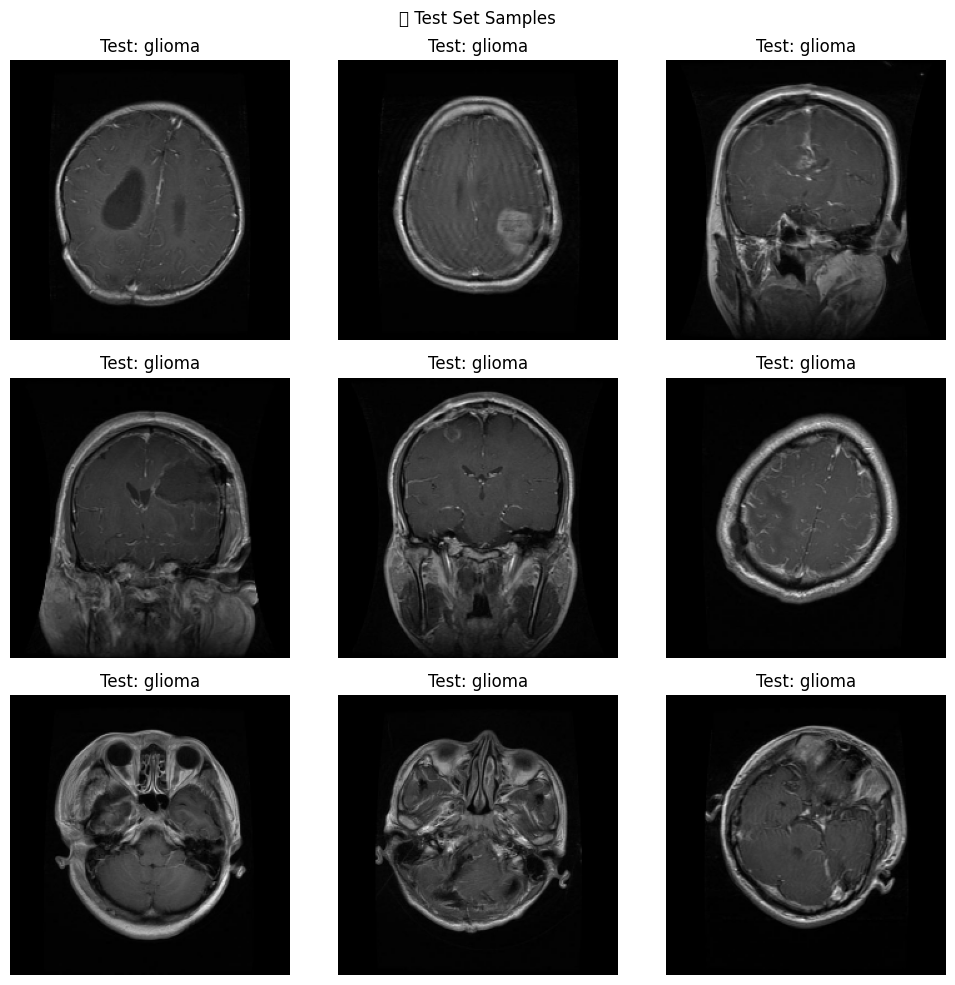


✅ Image preprocessing, normalization, and augmentation check complete!


In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf

print("\n--- ✅ Verifying Dataset Shapes and Visualizing Augmentations ---")

# Function to convert one-hot label to class name
def get_class_name_from_one_hot(label_tensor, class_names):
    label_index = tf.argmax(label_tensor).numpy()
    return class_names[label_index]

# Visualize one batch from the preprocessed training dataset
print("\n🔍 Preprocessed Training Batch Info:")
for images, labels in train_ds.take(1):
    print("✅ Images shape:", images.shape)  # (batch_size, height, width, channels)
    print("✅ Labels shape:", labels.shape)
    print("✅ Pixel range:", tf.reduce_min(images).numpy(), "to", tf.reduce_max(images).numpy())

    # Display up to 9 augmented images
    plt.figure(figsize=(10, 10))
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        class_name = get_class_name_from_one_hot(labels[i], CLASSES)
        plt.title(f"Augmented: {class_name}")
        plt.axis("off")
    plt.suptitle("📈 Augmented Training Samples")
    plt.tight_layout()
    plt.show()
    break  # Only one batch

# Visualize one batch from the preprocessed test dataset
print("\n🔍 Preprocessed Test Batch Info:")
for images, labels in test_ds.take(1):
    print("✅ Images shape:", images.shape)
    print("✅ Labels shape:", labels.shape)
    print("✅ Pixel range:", tf.reduce_min(images).numpy(), "to", tf.reduce_max(images).numpy())

    # Optional: Display a few test images
    plt.figure(figsize=(10, 10))
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        class_name = get_class_name_from_one_hot(labels[i], CLASSES)
        plt.title(f"Test: {class_name}")
        plt.axis("off")
    plt.suptitle("🧪 Test Set Samples")
    plt.tight_layout()
    plt.show()
    break

print("\n✅ Image preprocessing, normalization, and augmentation check complete!")


In [14]:
import tensorflow as tf
import os

# --- Configuration ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
AUGMENTED_TRAIN_DIR = "drive/MyDrive/dataset/augmented_train"
TEST_DIR = "drive/MyDrive/dataset/test"
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# --- Helper Functions ---
def count_images_in_directory(directory, classes):
    """Count images by scanning directory (safer than iterating dataset)"""
    counts = {}
    total = 0
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        count = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        counts[class_name] = count
        total += count
    return counts, total

def print_dataset_info(dataset, name):
    """Improved dataset verification function"""
    try:
        num_batches = tf.data.experimental.cardinality(dataset).numpy()
        if num_batches in (tf.data.experimental.INFINITE_CARDINALITY, tf.data.experimental.UNKNOWN_CARDINALITY):
            print(f"  {name}: Could not determine exact size (cardinality: {'infinite' if num_batches == tf.data.experimental.INFINITE_CARDINALITY else 'unknown'})")
            return None

        # Count by iterating
        count = 0
        for _ in dataset.unbatch():
            count += 1
        print(f"  {name}: {count} elements ({num_batches} batches of {BATCH_SIZE})")
        return count
    except Exception as e:
        print(f"  Error verifying {name}: {e}")
        return None

# --- Load and Split Dataset ---
# 1. Load full augmented dataset (without shuffling for controlled split)
augmented_train_ds_full = tf.keras.utils.image_dataset_from_directory(
    AUGMENTED_TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False  # Important for controlled split
)

# 2. Get total image count (using directory scan for reliability)
_, total_augmented_images = count_images_in_directory(AUGMENTED_TRAIN_DIR, CLASSES)
print(f"\nFound {total_augmented_images} augmented training images")

# 3. Calculate split sizes (80% train, 20% validation)
train_size = int(total_augmented_images * 0.8)
val_size = total_augmented_images - train_size

# 4. Calculate batch counts for splitting
total_batches = total_augmented_images // BATCH_SIZE
train_batches = train_size // BATCH_SIZE
val_batches = total_batches - train_batches

print(f"\nSplitting {total_augmented_images} images:")
print(f"  Training: {train_size} images ({train_batches} batches)")
print(f"  Validation: {val_size} images ({val_batches} batches)")

# 5. Split the dataset
train_ds = augmented_train_ds_full.take(train_batches)
val_ds = augmented_train_ds_full.skip(train_batches)

# 6. Apply preprocessing and optimization
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y),
                       num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y),
                   num_parallel_calls=AUTOTUNE)

# Add caching and prefetch for performance
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- Load Test Set ---
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False
)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y),
                     num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# --- Verification ---
print("\n--- Verifying Dataset Sizes ---")
print_dataset_info(train_ds, "Training Dataset")
print_dataset_info(val_ds, "Validation Dataset")
print_dataset_info(test_ds, "Test Dataset")

print("\n✅ Successfully split data into:")
print(f"  Training: {train_size} images")
print(f"  Validation: {val_size} images")
print(f"  Test: {tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE} images")

Found 1920 files belonging to 4 classes.

Found 1920 augmented training images

Splitting 1920 images:
  Training: 1536 images (48 batches)
  Validation: 384 images (12 batches)
Found 480 files belonging to 4 classes.

--- Verifying Dataset Sizes ---
  Training Dataset: 1536 elements (48 batches of 32)
  Validation Dataset: 384 elements (12 batches of 32)
  Test Dataset: 480 elements (15 batches of 32)

✅ Successfully split data into:
  Training: 1536 images
  Validation: 384 images
  Test: 480 images


## **3. Conventional Machine Learning Approach**

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV # For tuning conventional ML models
from collections import defaultdict

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
import tensorflow as tf
from itertools import cycle

# Ensure CLASSES is defined
try:
    _ = CLASSES
except NameError:
    CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
    print("WARNING: 'CLASSES' not found. Using default classes.")

NUM_CLASSES = len(CLASSES)

def plot_learning_curves(history, test_metrics=None):
    """
    Plot training/validation learning curves with optional test set reference

    Args:
        history: Keras History object from model.fit()
        test_metrics: Dict containing test loss and accuracy (optional)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot Loss Curves
    ax1.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    if test_metrics:
        ax1.axhline(y=test_metrics['loss'], color='green', linestyle='--', linewidth=2,
                    label=f'Test Loss: {test_metrics["loss"]:.4f}')
    ax1.set_title('Model Loss Evolution', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Plot Accuracy Curves
    ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
    if test_metrics:
        ax2.axhline(y=test_metrics['accuracy'], color='green', linestyle='--', linewidth=2,
                    label=f'Test Accuracy: {test_metrics["accuracy"]:.4f}')
    ax2.set_title('Model Accuracy Evolution', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, history, test_ds, model_name="Model"):
    """
    Comprehensive model evaluation with learning curves and metrics

    Args:
        model: Trained Keras model
        history: Training history object
        test_ds: Test dataset
        model_name: Name for display purposes
    """
    # 1. Evaluate test set
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    test_metrics = {'loss': test_loss, 'accuracy': test_acc}

    # 2. Get predictions for metrics
    y_true, y_pred, y_prob = [], [], []
    for images, labels in test_ds:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        prob = model.predict(images, verbose=0)
        y_prob.extend(prob)
        y_pred.extend(np.argmax(prob, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # 3. Print metrics
    print(f"\n=== {model_name} Evaluation ===")
    print(f"\nTraining Final Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Validation Final Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # 4. Plot learning curves
    plot_learning_curves(history, test_metrics)

    # 5. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{model_name} - Test Set Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    # 6. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

    # 7. ROC AUC (if multi-class)
    if NUM_CLASSES > 2:
        try:
            y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=NUM_CLASSES)
            roc_auc = roc_auc_score(y_true_one_hot, y_prob, multi_class='ovr', average='macro')
            print(f"Macro-averaged ROC AUC: {roc_auc:.4f}")

            # Plot ROC curves
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])

            for i, color in zip(range(NUM_CLASSES), colors):
                fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            plt.figure(figsize=(10, 8))
            for i, color, class_name in zip(range(NUM_CLASSES), colors, CLASSES):
                plt.plot(fpr[i], tpr[i], color=color, lw=2,
                         label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title(f'{model_name} - ROC Curves', fontsize=14)
            plt.legend(loc="lower right")
            plt.show()
        except Exception as e:
            print(f"Could not calculate ROC metrics: {e}")

In [26]:
# Ensure CLASSES is defined for consistent execution in case this block is run standalone.
try:
    _ = CLASSES
except NameError:
    CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
    print("WARNING: 'CLASSES' not found. Using default mock classes. Ensure previous data prep code runs first.")

NUM_CLASSES = len(CLASSES)

# --- Utility Functions for Evaluation ---
def evaluate_model(model_name, y_true, y_pred, y_prob=None):
    """
    Evaluates a classification model and prints key metrics and plots.

    Args:
        model_name (str): Name of the model being evaluated.
        y_true (np.array): True labels (integers).
        y_pred (np.array): Predicted labels (integers).
        y_prob (np.array, optional): Predicted probabilities. Required for ROC AUC. Defaults to None.
    """
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import tensorflow as tf

    print(f"\n--- Performance Evaluation: {model_name} ---")
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-averaged F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # 🔥 Plot Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

    # 🔍 Optional: ROC AUC (multi-class)
    if y_prob is not None and NUM_CLASSES > 2:
        try:
            from sklearn.metrics import roc_auc_score
            y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=NUM_CLASSES)
            roc_auc = roc_auc_score(y_true_one_hot, y_prob, multi_class='ovr', average='macro')
            print(f"\nMacro-averaged ROC AUC: {roc_auc:.4f}")
        except Exception as e:
            print(f"Could not calculate ROC AUC: {e}")


## **3.1 Random Forest**

In [17]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Config ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
AUGMENTED_TRAIN_DIR = "drive/MyDrive/dataset/augmented_train"
TEST_DIR = "drive/MyDrive/dataset/test"
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
NUM_CLASSES = len(CLASSES)

# --- Helper: Count images ---
def count_images(directory, classes):
    total = 0
    for c in classes:
        class_dir = os.path.join(directory, c)
        total += len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
    return total

# --- Helper: Convert tf.data.Dataset to NumPy arrays ---
def dataset_to_numpy(dataset):
    X, y = [], []
    for images, labels in dataset.unbatch():
        X.append(images.numpy().flatten())      # Flatten image
        y.append(np.argmax(labels.numpy()))     # Class index
    return np.array(X), np.array(y)

# --- Load dataset (with shuffle for TF split) ---
augmented_train_ds_full = tf.keras.utils.image_dataset_from_directory(
    AUGMENTED_TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False
)

# --- TF Split for CNN ---
total_batches = tf.data.experimental.cardinality(augmented_train_ds_full).numpy()
train_batches = int(total_batches * 0.8)
val_batches = total_batches - train_batches

train_ds = augmented_train_ds_full.take(train_batches)
val_ds = augmented_train_ds_full.skip(train_batches)

# Normalization and prefetch
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)

print("\n✅ TensorFlow datasets ready (for CNNs)")
print(f"  Train batches: {train_batches}, Validation batches: {val_batches}")

# --- sklearn Split for Random Forest ---
# Convert full dataset to NumPy
X_full, y_full = dataset_to_numpy(augmented_train_ds_full)
X_test, y_test = dataset_to_numpy(test_ds)

# Stratified split for train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    stratify=y_full,
    random_state=42
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


print("✅ sklearn datasets ready (for Random Forest)")
print(f"  X_train_scaled shape: {X_train_scaled.shape}, X_val_scaled shape: {X_val_scaled.shape}")

Found 1920 files belonging to 4 classes.
Found 480 files belonging to 4 classes.

✅ TensorFlow datasets ready (for CNNs)
  Train batches: 48, Validation batches: 12
✅ sklearn datasets ready (for Random Forest)
  X_train_scaled shape: (1536, 150528), X_val_scaled shape: (384, 150528)


In [ ]:
import numpy as np

def extract_images_and_labels(dataset):
    image_list = []
    label_list = []

    for images, labels in dataset.unbatch():
        image_list.append(images.numpy().flatten())  # Flatten image (H*W*C)
        label_list.append(tf.argmax(labels).numpy()) # Convert one-hot to class index

    return np.array(image_list), np.array(label_list)

# Extract from preprocessed train_ds and test_ds
X_train, y_train = extract_images_and_labels(train_ds)
X_test, y_test = extract_images_and_labels(test_ds)
X_val, y_val = extract_images_and_labels(val_ds)

print(f"Train set shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, Labels: {y_test.shape}")
print(f"Validation set shape: {X_val.shape}, Labels: {y_val.shape}")


Train set shape: (1920, 150528), Labels: (1920,)
Test set shape: (480, 150528), Labels: (480,)


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# Assume X_train, y_train, X_val, y_val, X_test, y_test are already defined from the previous code
# Assume CLASSES and NUM_CLASSES are also defined

# Standardize pixel data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# Define parameter grid for tuning (can be more or less extensive)
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 0.5, 0.7], # Added float options
#     'bootstrap': [True, False]
# }

# Simplified param_grid to run faster if needed
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}


# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Setup GridSearchCV
# Use the scaled training data for GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,           # 3-fold cross-validation
    n_jobs=-1,      # Use all available cores
    verbose=2,
    scoring='accuracy' # Use accuracy or f1_macro
)

print("Starting GridSearchCV for Random Forest...")
grid_search.fit(X_train_scaled, y_train)

print("\nBest hyperparameters found:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

print("\nEvaluating the best Random Forest model...")

# Predict on validation set
y_val_pred = best_rf.predict(X_val_scaled)
# Get probabilities for potential ROC AUC calculation later
y_val_prob = best_rf.predict_proba(X_val_scaled)

# Evaluate on validation set
evaluate_model("Random Forest (Validation)", y_val, y_val_pred, y_val_prob)


# Predict on test set
y_test_pred = best_rf.predict(X_test_scaled)
# Get probabilities for potential ROC AUC calculation later
y_test_prob = best_rf.predict_proba(X_test_scaled)


# Evaluate on test set
evaluate_model("Random Forest (Test)", y_test, y_test_pred, y_test_prob)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)



--- Performance Evaluation: Random Forest ---
Accuracy: 0.7521
Macro-averaged F1 Score: 0.7477

Classification Report:
              precision    recall  f1-score   support

      glioma       0.78      0.90      0.84       120
  meningioma       0.64      0.57      0.60       120
     notumor       0.79      0.70      0.74       120
   pituitary       0.78      0.84      0.81       120

    accuracy                           0.75       480
   macro avg       0.75      0.75      0.75       480
weighted avg       0.75      0.75      0.75       480


Confusion Matrix:
[[108   8   0   4]
 [ 16  68  21  15]
 [  9  18  84   9]
 [  5  13   1 101]]


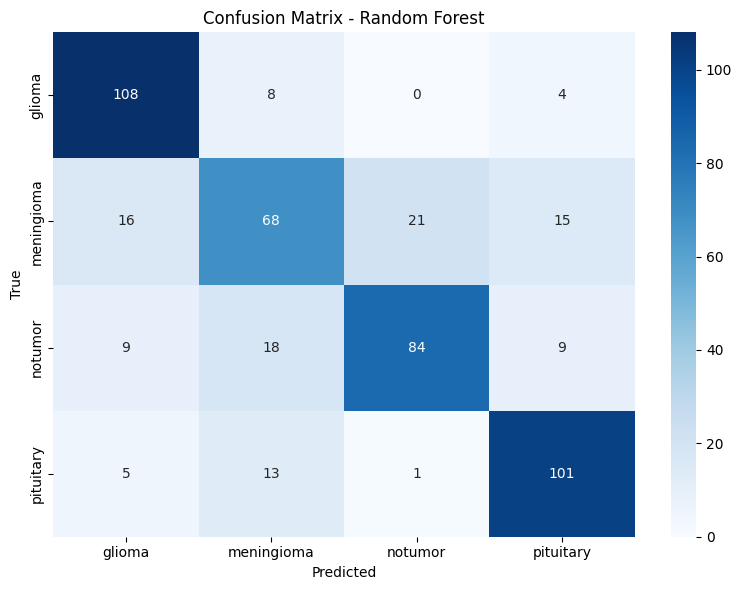


Macro-averaged ROC AUC: 0.9336


In [ ]:
evaluate_model("Random Forest", y_test, y_pred_rf, y_prob_rf)

In [ ]:
# --- Prepare data for Scikit-learn models (Random Forest) ---
# Extract images and labels into NumPy arrays from TensorFlow datasets
print("Preparing data for Scikit-learn models (flattening images)...")
X_train_np = []
y_train_np = []
for images, labels in train_ds.unbatch(): # Unbatch to get individual samples
    X_train_np.append(images.numpy().flatten()) # Flatten each image (IMG_HEIGHT*IMG_WIDTH*3 features)
    y_train_np.append(labels.numpy())

X_test_np = []
y_test_np = []
# Store original images and labels for visual vetting
X_test_original_images = []
y_test_original_labels = []

for images, labels in test_ds.unbatch():
    X_test_np.append(images.numpy().flatten())
    y_test_np.append(labels.numpy())
    X_test_original_images.append(images.numpy())
    y_test_original_labels.append(labels.numpy())


X_train_np = np.array(X_train_np)
y_train_np = np.array(y_train_np)
X_test_np = np.array(X_test_np)
y_test_np = np.array(y_test_np)
X_test_original_images = np.array(X_test_original_images)
y_test_original_labels = np.array(y_test_original_labels)


print(f"Train data shape for Scikit-learn: {X_train_np.shape}, Labels: {y_train_np.shape}")
print(f"Test data shape for Scikit-learn: {X_test_np.shape}, Labels: {y_test_np.shape}")
print(f"Original Test Images shape: {X_test_original_images.shape}, Labels: {y_test_original_labels.shape}")

Preparing data for Scikit-learn models (flattening images)...
Train data shape for Scikit-learn: (1920, 150528), Labels: (1920, 4)
Test data shape for Scikit-learn: (480, 150528), Labels: (480, 4)
Original Test Images shape: (480, 224, 224, 3), Labels: (480, 4)


In [ ]:
# --- 1. Conventional Machine Learning Approach: Random Forest ---
print("\n" + "="*80)
print("1. Conventional Machine Learning Approach: Random Forest")
print("="*80)

# O Model Training and Tuning
print("\n--- Training Random Forest Model ---")
# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define a smaller parameter grid for quicker demonstration.
# In a real project, you would explore a wider range.
param_grid = {
    'n_estimators': [50, 100], # Number of trees in the forest
    'max_depth': [10, 20, None], # Maximum depth of the tree (None means unlimited)
    'min_samples_leaf': [1, 5], # Minimum number of samples required at each leaf node
}

# GridSearchCV for hyperparameter tuning with cross-validation
print("Starting GridSearchCV for Random Forest tuning...")
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3,
                           scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_np, y_train_np)

best_rf_model = grid_search.best_estimator_
print(f"Best Random Forest Parameters: {grid_search.best_params_}")
print(f"Best Random Forest Cross-validation Accuracy: {grid_search.best_score_:.4f}")

# O Machine Learning Inference
print("\n--- Making Predictions with Best Random Forest Model ---")
y_pred_rf = best_rf_model.predict(X_test_np)
y_prob_rf = best_rf_model.predict_proba(X_test_np)

# O Performance Evaluation
evaluate_model("Random Forest", y_test_np, y_pred_rf, y_prob_rf)

# O Visual Vetting: Random Forest Predictions
print("\n--- Visual Vetting: Random Forest Predictions ---")
num_samples_to_show = 5
plt.figure(figsize=(15, 6))
for i in range(num_samples_to_show):
    ax = plt.subplot(2, num_samples_to_show, i + 1)
    plt.imshow(X_test_original_images[i]) # Use original image (normalized [0,1])
    plt.title(f"True: {CLASSES[y_test_original_labels[i]]}\nPred: {CLASSES[y_pred_rf[i]]}")
    plt.axis("off")
plt.suptitle("Random Forest: Ground Truth vs. Predicted Labels on Test Set")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# O Strengths and Weaknesses Discussion (Integrated into output)
print("\n--- Random Forest: Strengths and Weaknesses ---")
print("Strengths:")
print("- Robustness: Less prone to overfitting than individual decision trees due to ensembling.")
print("- Handles High-Dimensionality: Can work with many input features (flattened image pixels).")
print("- Feature Importance: Can provide insights into which pixel regions/features were most important.")
print("- Parallelizable: Individual trees can be built independently, making training efficient.")
print("- Relatively simple to use with scikit-learn.")
print("Weaknesses:")
print("- Performance Ceiling: May not achieve state-of-the-art accuracy compared to deep learning models for complex image tasks, as its feature extraction is not learned end-to-end.")
print("- Computational Cost: Can be memory-intensive if many trees or very high-dimensional features are used.")
print("- Interpretability: While individual trees are interpretable, the ensemble as a whole is less intuitive.")
print("="*80 + "\n")


1. Conventional Machine Learning Approach: Random Forest

--- Training Random Forest Model ---
Starting GridSearchCV for Random Forest tuning...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Best Random Forest Cross-validation Accuracy: 0.4896

--- Making Predictions with Best Random Forest Model ---

--- Performance Evaluation: Random Forest ---
Accuracy: 0.6146

Classification Report:
              precision    recall  f1-score   support

      glioma       0.86      0.85      0.85       120
  meningioma       0.89      0.35      0.50       120
     notumor       0.82      0.45      0.58       120
   pituitary       0.89      0.81      0.85       120

   micro avg       0.87      0.61      0.72       480
   macro avg       0.86      0.61      0.70       480
weighted avg       0.86      0.61      0.70       480
 samples avg       0.61      0.61      0.61       480


Confusion M

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: multilabel-indicator is not supported

## **4. Deep Learning Approaches**

In [ ]:
# --- 2. Deep Learning Approach 1: Convolutional Neural Networks (CNNs) ---
print("\n" + "="*80)
print("2. Deep Learning Approach 1: Convolutional Neural Networks (CNNs)")
print("="*80)

# O Model Training and Tuning
print("\n--- Building and Training Custom CNN Model ---")

IMAGE_SIZE = (224, 224)
IMG_HEIGHT, IMG_WIDTH = IMAGE_SIZE  # Unpack the tuple

# Define the CNN architecture
cnn_model = tf.keras.Sequential([
    # Input layer expects images of IMG_HEIGHT x IMG_WIDTH with 3 channels
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Dropout for regularization
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax') # Output layer with softmax for multi-class classification
])

# Compile the model
# Use SparseCategoricalCrossentropy because labels are integers (0, 1, 2, 3)
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

cnn_model.summary()

# Define callbacks for training
# Early Stopping: Stop training if validation accuracy doesn't improve for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# Model Checkpoint: Save the best model weights based on validation accuracy
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
# Using test_ds as validation_data for monitoring during training.
print("Training CNN...")
history_cnn = cnn_model.fit(
    train_ds,
    epochs=50, # Set a reasonably high number of epochs, EarlyStopping will stop it
    validation_data=test_ds, # Using test_ds as validation for monitoring
    callbacks=[early_stopping, model_checkpoint]
)

# O Machine Learning Inference
print("\n--- Making Predictions with Best CNN Model ---")
# Load the best model saved by ModelCheckpoint
best_cnn_model = tf.keras.models.load_model('best_cnn_model.keras')

y_prob_cnn = best_cnn_model.predict(test_ds)
y_pred_cnn = np.argmax(y_prob_cnn, axis=1)

# Get true labels for comparison (from test_ds). This needs to be done once for all DL models.
# Make sure y_true_dl_models is available for other DL model evaluations.
y_true_dl_models = np.concatenate([labels.numpy() for images, labels in test_ds], axis=0)


# O Performance Evaluation
evaluate_model("Custom CNN", y_true_dl_models, y_pred_cnn, y_prob_cnn)

# O Visual Vetting: CNN Predictions
print("\n--- Visual Vetting: Custom CNN Predictions ---")
num_samples_to_show = 5
plt.figure(figsize=(15, 6))
# Need to iterate through test_ds again to get images in the correct order for visual comparison
# Or, use X_test_original_images which was already collected
for i in range(num_samples_to_show):
    ax = plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(X_test_original_images[i])
    plt.title(f"True: {CLASSES[y_test_original_labels[i]]}\nPred: {CLASSES[y_pred_cnn[i]]}")
    plt.axis("off")
plt.suptitle("Custom CNN: Ground Truth vs. Predicted Labels on Test Set")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# O Strengths and Weaknesses Discussion
print("\n--- Custom CNN: Strengths and Weaknesses ---")
print("Strengths:")
print("- Automatic Feature Learning: Learns hierarchical features directly from raw image data, eliminating manual feature engineering.")
print("- High Performance: Typically achieves state-of-the-art results in image classification given sufficient data.")
print("- Spatial Invariance: Pooling layers provide a degree of invariance to small shifts and distortions.")
print("- Scalability: Can be scaled to handle very large datasets and complex image patterns.")
print("Weaknesses:")
print("- Data Hungry: Requires a substantial amount of labeled data to train effectively and avoid overfitting.")
print("- Computational Cost: Training can be very computationally expensive, especially for deeper networks.")
print("- Black Box: Less interpretable than conventional models; challenging to understand learned features.")
print("- Hyperparameter Sensitivity: Performance is highly sensitive to architecture and hyperparameters.")
print("="*80 + "\n")


2. Deep Learning Approach 1: Convolutional Neural Networks (CNNs)

--- Building and Training Custom CNN Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN...
Epoch 1/50
22/60 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - accuracy: 0.2865 - loss: 1.6120

KeyboardInterrupt: 

## **4.1 Convolutional Neural Networks (CNNs)**


2. Deep Learning Approach 1: Convolutional Neural Networks (CNNs)

--- Building and Training Custom CNN Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3356 - loss: 1.5283
Epoch 1: val_accuracy improved from -inf to 0.41176, saving model to best_cnn_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.3382 - loss: 1.5214 - val_accuracy: 0.4118 - val_loss: 1.2200
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5240 - loss: 1.1241
Epoch 2: val_accuracy improved from 0.41176 to 0.45455, saving model to best_cnn_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.5238 - loss: 1.1232 - val_accuracy: 0.4545 - val_loss: 1.1206
Epoch 3/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5398 - loss: 1.0363
Epoch 3: val_accuracy improved from 0.45455 to 0.55080, saving model to best_cnn_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.5433 - loss: 1.0340 - val_accuracy: 0.5508 - val_loss: 1.0278
Epoch 4/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6292 - loss: 0.9510
Epoch 4: val_

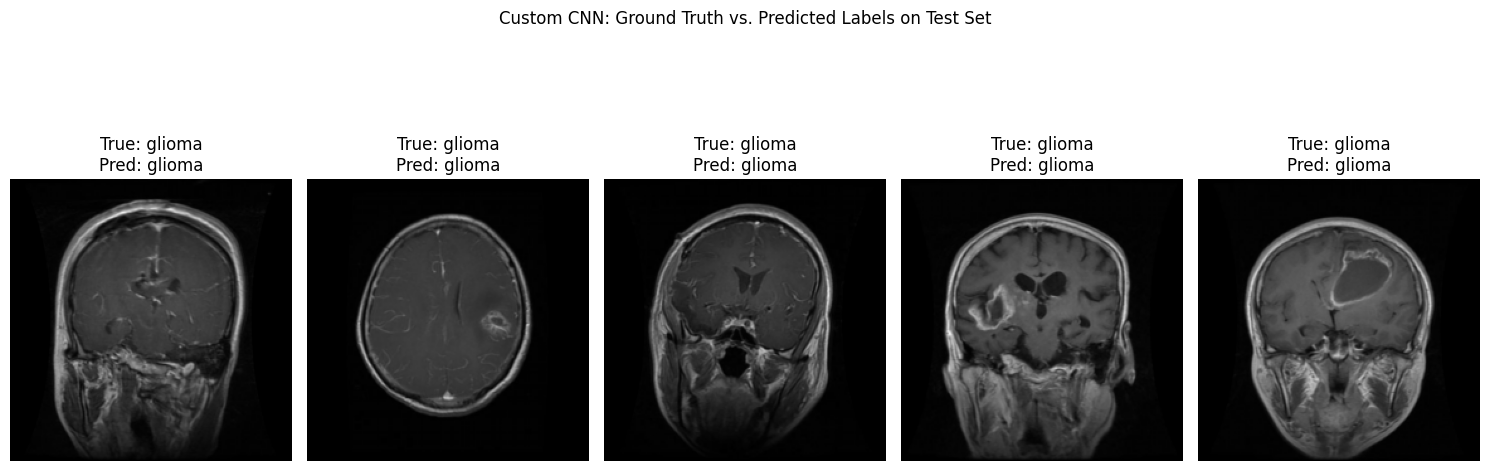


--- Custom CNN: Strengths and Weaknesses ---
Strengths:
- Automatic Feature Learning: Learns hierarchical features directly from raw image data, eliminating manual feature engineering.
- High Performance: Typically achieves state-of-the-art results in image classification given sufficient data.
- Spatial Invariance: Pooling layers provide a degree of invariance to small shifts and distortions.
- Scalability: Can be scaled to handle very large datasets and complex image patterns.
Weaknesses:
- Data Hungry: Requires a substantial amount of labeled data to train effectively and avoid overfitting.
- Computational Cost: Training can be very computationally expensive, especially for deeper networks.
- Black Box: Less interpretable than conventional models; challenging to understand learned features.
- Hyperparameter Sensitivity: Performance is highly sensitive to architecture and hyperparameters.



In [ ]:
# --- 2. Deep Learning Approach 1: Convolutional Neural Networks (CNNs) ---
print("\n" + "="*80)
print("2. Deep Learning Approach 1: Convolutional Neural Networks (CNNs)")
print("="*80)

# O Model Training and Tuning
print("\n--- Building and Training Custom CNN Model ---")

# Define the CNN architecture
cnn_model = tf.keras.Sequential([
    # Input layer expects images of IMG_HEIGHT x IMG_WIDTH with 3 channels
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Dropout for regularization
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax') # Output layer with softmax for multi-class classification
])

# Compile the model
# Use SparseCategoricalCrossentropy because labels are integers (0, 1, 2, 3)
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

cnn_model.summary()

# Define callbacks for training
# Early Stopping: Stop training if validation accuracy doesn't improve for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# Model Checkpoint: Save the best model weights based on validation accuracy
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
# Using test_ds as validation_data for monitoring during training.
print("Training CNN...")
history_cnn = cnn_model.fit(
    train_ds,
    epochs=50, # Set a reasonably high number of epochs, EarlyStopping will stop it
    validation_data=test_ds, # Using test_ds as validation for monitoring
    callbacks=[early_stopping, model_checkpoint]
)

# O Machine Learning Inference
print("\n--- Making Predictions with Best CNN Model ---")
# Load the best model saved by ModelCheckpoint
best_cnn_model = tf.keras.models.load_model('best_cnn_model.keras')

y_prob_cnn = best_cnn_model.predict(test_ds)
y_pred_cnn = np.argmax(y_prob_cnn, axis=1)

# Get true labels for comparison (from test_ds). This needs to be done once for all DL models.
# Make sure y_true_dl_models is available for other DL model evaluations.
y_true_dl_models = np.concatenate([labels.numpy() for images, labels in test_ds], axis=0)


# O Performance Evaluation
evaluate_model("Custom CNN", y_true_dl_models, y_pred_cnn, y_prob_cnn)

# O Visual Vetting: CNN Predictions
print("\n--- Visual Vetting: Custom CNN Predictions ---")
num_samples_to_show = 5
plt.figure(figsize=(15, 6))
# Need to iterate through test_ds again to get images in the correct order for visual comparison
# Or, use X_test_original_images which was already collected
for i in range(num_samples_to_show):
    ax = plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(X_test_original_images[i])
    plt.title(f"True: {CLASSES[y_test_original_labels[i]]}\nPred: {CLASSES[y_pred_cnn[i]]}")
    plt.axis("off")
plt.suptitle("Custom CNN: Ground Truth vs. Predicted Labels on Test Set")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# O Strengths and Weaknesses Discussion
print("\n--- Custom CNN: Strengths and Weaknesses ---")
print("Strengths:")
print("- Automatic Feature Learning: Learns hierarchical features directly from raw image data, eliminating manual feature engineering.")
print("- High Performance: Typically achieves state-of-the-art results in image classification given sufficient data.")
print("- Spatial Invariance: Pooling layers provide a degree of invariance to small shifts and distortions.")
print("- Scalability: Can be scaled to handle very large datasets and complex image patterns.")
print("Weaknesses:")
print("- Data Hungry: Requires a substantial amount of labeled data to train effectively and avoid overfitting.")
print("- Computational Cost: Training can be very computationally expensive, especially for deeper networks.")
print("- Black Box: Less interpretable than conventional models; challenging to understand learned features.")
print("- Hyperparameter Sensitivity: Performance is highly sensitive to architecture and hyperparameters.")
print("="*80 + "\n")

## **4.2 MobileNetV2**

## **4.3 Graph Convolutional Networks (GCNs)**